In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from python_proj.utils.util import safe_save_fig, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
experiment_name = "ftc_collaborative_logit_model"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/{experiment_name}"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()


# Loads dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Loads first-time contributor data frame.
print(f"{len(df)=}")
print(f"{len(df.columns)=}")

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]
independent_fields = [
    field
    for field in df.columns
    if (field not in metadata_fields and field not in dependent_fields)
]

df.describe()

len(df)=1216221
len(df.columns)=43


,ID,Project Name,Submitter ID,PR Number,Closed At,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,1.216221e+06,1.216221e+06,1216221.0,1216221.0,1216221.0,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,9.081164e+05,8.677039e+03,0.0,0.0,0.0,5.027905e-01,4.027001e-01,9.860918e-02,3.749753e-01,5.920373e-02,...,1.145965e-02,1.972030e-02,7.959556e-02,1.343719e-01,9.534855e-03,1.751229e-02,6.396949e-02,6.042839e-02,2.191224e-02,4.468485e-02
std,5.243531e+05,5.806587e+03,0.0,0.0,0.0,4.710578e-01,4.523420e-01,2.908001e-01,4.479160e-01,2.284681e-01,...,5.401390e-02,8.011601e-02,1.179346e-01,1.749533e-01,5.258916e-02,8.239552e-02,9.937732e-02,1.003326e-01,8.736962e-02,1.013914e-01
min,0.000000e+00,4.300000e+01,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.542500e+05,3.224000e+03,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.078700e+05,8.413000e+03,0.0,0.0,0.0,6.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,8.438514e-03,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.362318e+06,1.357000e+04,0.0,0.0,0.0,1.000000e+00,9.387755e-01,0.000000e+00,9.230769e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,9.891430e-02,8.847414e-02,0.000000e+00,2.582313e-02
max,1.815970e+06,2.009400e+04,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [2]:
print(list(df.columns))

['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At', 'PullRequestIsMerged', 'ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystem

In [3]:
pairs = [
    (
        "",
        "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
        "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",
    ),
    (
        "",
        "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
        "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",
    ),
]

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import numpy as np


def scale(_df: pd.DataFrame, scaled_fields: pd.Series):
    scaled_df = _df.copy()

    for feature in scaled_fields:
        feature_min = scaled_df[feature].min()
        feature_max = scaled_df[feature].max()
        feature_delta = feature_max - feature_min

        scaled_df[feature] = (
            scaled_df[feature].subtract(feature_min).divide(feature_delta)
        )

    return scaled_df


for name, count, ratio in pairs:
    # Gets all non-zero PR count entries.
    t_df = df[df[count].gt(0)]
    t_df = scale(t_df, [count])

    # Creates segments.
    tr = df[df[count].gt(0.5) & df[ratio].gt(0.5)].count()[count]
    tl = df[df[count].gt(0.5) & df[ratio].lt(0.5)].count()[count]
    br = df[df[count].lt(0.5) & df[ratio].gt(0.5)].count()[count]
    bl = df[df[count].lt(0.5) & df[ratio].lt(0.5)].count()[count]
    matrix = np.array([tr, tl, br, bl])

    # Does Chi-squaret test
    res = chisquare(matrix)
    print(f"{name}: {matrix=}, {res=}")

: matrix=array([  12415,    5111,  177619, 1021076]), res=Power_divergenceResult(statistic=2317100.5311460663, pvalue=0.0)


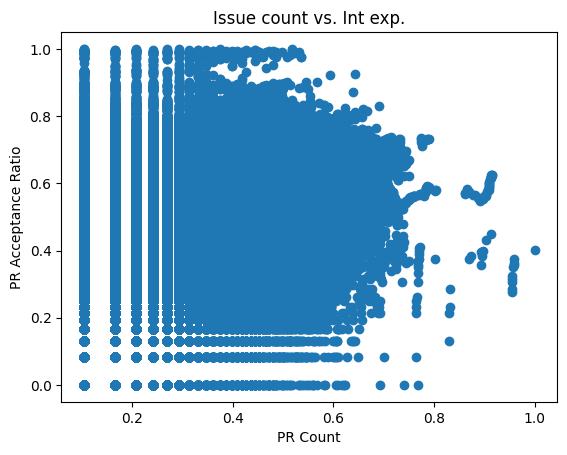

In [5]:
import matplotlib.pyplot as plt

for name, count, ratio in pairs:
    plt.cla()
    plt.title(f"Issue count vs. Int exp.")
    t_df = df[df[count].gt(0)]
    plt.scatter(t_df[count], t_df[ratio])
    plt.xlabel("PR Count")
    plt.ylabel("PR Acceptance Ratio")
    plt.show()